In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from scipy.special import comb

def return_data(N, f, noise):
    ''' data generating function '''
    X = np.random.uniform(0,6, N)
    Y = f(X) + noise*np.random.rand(N)
    return X, Y

def plot(X,Y):
    plt.xlabel(r"$x$", fontsize=20); plt.ylabel(r"$y$", fontsize=20)
    plt.xlim(0,6); plt.ylim(-1.5, 2.5)
    plt.scatter(X, Y, alpha=0.5)
    
def get_xvect(x, order):
    x = x.reshape(len(x), 1)
    xvect = np.ones((len(x), 1))
    for d in range(1, order+1):
        xvect = np.concatenate([xvect, x**d], axis=1)
    return xvect

def get_X(x, order):
    N = len(x)
    xvect = get_xvect(x, order)
    xvectT = xvect.T
    return np.matmul(xvectT, xvect)/N

def get_alpha(x, y, order):
    N = len(x)
    xvect = get_xvect(x, order)
    y = y.reshape(1, N)
    alpha = np.matmul(y, xvect)/N
    return alpha.reshape(order+1, 1)

def get_w(data, order):
    x, y = data
    alpha = get_alpha(x, y, order)
    Xinv = np.linalg.inv(get_X(x, order))
    return np.matmul(Xinv, alpha)

def get_regularized_w(data, order, epsilon=0.1):
    x, y = data
    alpha = get_alpha(x, y, order)
    Xinv = np.linalg.inv(get_X(x, order) + epsilon*np.identity(order+1))
    return np.matmul(Xinv, alpha)

class Polynomial():
    def __init__(self, w=None):
        self.order = np.product(w.shape)-1
        #self.len_shape = len(w.shape)
        self.w = w
        
    def __call__(self, x):
        y = 0
        for d in range(self.order+1):
            y += self.w[d]*x**d
        return y
    
def binomial(k, K, theta):
    return comb(K, k, exact=True)*theta**k*(1-theta)**(K-k)

def plot_mass(K, theta):
    half1 = np.arange(K//2)
    half2 = np.arange(K//2) + K//2
    p1 = []
    p2 = []
    for k in half1:
        p1.append(binomial(k, K, theta))
    for k in half2:
        p2.append(binomial(k, K, theta))
    p = np.sum(p2)
    plt.title(r"$\theta={:.2}$, {}-ensemble".format(theta, K), fontsize=20)
    plt.xlabel("k", fontsize=20)
    plt.bar(half1, p1, color="#1E7F00", linewidth=0)
    plt.bar(half2, p2, color="red", linewidth=0)
    plt.show()
    print("P={}".format(p))
    
def measure(model, test_inputs, test_labels):
    return np.mean(np.argmax(model.predict(test_inputs), axis=1) == test_labels.reshape(10000))

def measure_esb(models, test_inputs, test_labels):
    preds = None
    for model in models:
        pred = np.argmax(model.predict(test_inputs), axis=1).reshape(10000, 1)
        if not preds is None:
            preds = np.concatenate([preds, pred], axis=1)
        else:
            preds = pred
    majority_votes = [np.argmax(np.bincount(vote)) for vote in preds]
    return np.mean(np.array(majority_votes) == test_labels.reshape(10000))

class CNNModel(tf.keras.Model): # モデル設計
    def __init__(self, dropout=False, BN=True, L2reg_weight=0):
        super(CNNModel, self).__init__()
        # to render .summary() correctly, fixing input & output
        # https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model
        self.c1 = tf.keras.layers.Conv2D(32, (3,3), kernel_regularizer=tf.keras.regularizers.l2(L2reg_weight))
        #self.c12 = tf.keras.layers.Conv2D(32, (3,3))
        self.c2 = tf.keras.layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.l2(L2reg_weight))
        self.c3 = tf.keras.layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.l2(L2reg_weight))
        self.f = tf.keras.layers.Flatten()
        self.l1 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(L2reg_weight))
        self.l2 = tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(L2reg_weight))
        self.dropout = dropout
        self.BN = BN
        if dropout:
            self.dropout1 = tf.keras.layers.Dropout(0.5)
            self.dropout2 = tf.keras.layers.Dropout(0.5)
            self.dropout3 = tf.keras.layers.Dropout(0.5)
        if BN:
            self.bn1 = tf.keras.layers.BatchNormalization()
            self.bn2 = tf.keras.layers.BatchNormalization()
            self.bn3 = tf.keras.layers.BatchNormalization()
            self.bn4 = tf.keras.layers.BatchNormalization()
            
    def call(self, x):
        if self.dropout and not self.BN:
            h = tf.keras.activations.relu(self.dropout1(self.c1(x)))
            h = tf.keras.activations.relu(self.dropout2(self.c2(h)))
            h = tf.keras.activations.relu(self.dropout3(self.c3(h)))
            h = self.f(h)
            h = tf.keras.activations.relu(self.l1(h))
            h = tf.keras.activations.softmax(self.l2(h))
            return h
        elif self.BN and not self.dropout:
            h = tf.keras.activations.relu(self.bn1(self.c1(x)))
            h = tf.keras.activations.relu(self.bn2(self.c2(h)))
            h = tf.keras.activations.relu(self.bn3(self.c3(h)))
            h = self.f(h)
            h = tf.keras.activations.relu(self.bn4(self.l1(h)))
            h = tf.keras.activations.softmax(self.l2(h))
            return h
        elif self.BN and self.dropout:
            h = tf.keras.activations.relu(self.dropout1(self.bn1(self.c1(x))))
            h = tf.keras.activations.relu(self.dropout2(self.bn2(self.c2(h))))
            h = tf.keras.activations.relu(self.dropout3(self.bn3(self.c3(h))))
            h = self.f(h)
            h = tf.keras.activations.relu(self.bn4(self.l1(h)))
            h = tf.keras.activations.softmax(self.l2(h))
            return h
        else:
            h = tf.keras.activations.relu(self.c1(x))
            h = tf.keras.activations.relu(self.c2(h))
            h = tf.keras.activations.relu(self.c3(h))
            h = self.f(h)
            h = tf.keras.activations.relu(self.l1(h))
            h = tf.keras.activations.softmax(self.l2(h))
            return h
        
    def summary(self):
        x = tf.keras.Input(shape=(28, 28, 1))
        return (tf.keras.Model(inputs=[x], outputs=self.call(x))).summary()

##### CIFAR-10 #####
cifar10 = tf.keras.datasets.cifar10 
(X, Y), (X_test, Y_test) = cifar10.load_data()
train_images = X/255.0
train_labels = Y
test_images = X_test/255
test_labels = Y_test

## 6-1. まだ解説していないテクニック
まずは深層学習に限らず教師ありの場合に適用可能なテクニック
* モデルの正則化
* アンサンブル学習

について説明しましょう。この2つは共に汎化性能を上げる可能性のあるテクニックで、実用上重要です。

### モデルの正則化
機械学習モデルでは、凡例から見たことのない例に適応させるために、何らかのバイアス([帰納バイアス(inductive bias)](https://en.wikipedia.org/wiki/Inductive_bias)) を暗黙のうちに仮定している場合があります。深層ニューラルネットでは例えば
* 畳み込み演算は画像処理に適した特性(並進対称性など)を持っている
* アテンション機構はタスク処理のため何らかの特徴量に注意を向けるように仕向けられている
* 深層ニューラルネットの階層構造

などが帰納バイアスを含んでいると考えられます。ところで、[2節](#2-kullback-leibler-ダイバージェンスと汎化) の内容を思い出すと、訓練パラメータが多すぎたり、モデルのカバーできる領域が大きすぎたりするとoverfittingのおそれがあるのでした。そういう意味では
* 訓練パラメータが大きくなりすぎないこと

も帰納バイアスの一種と思えます。このような制限をかける手法を正則化といいます。

#### 誤差関数のペナルティによる正則化
機械学習でしばしば用いられるのが、誤差関数にoverfittingを防ぐための正則化を入れることです。例えば冒頭の多項式フィッティングで考えてみましょう。多項式フィッティングの問題は最小二乗法であれば、 $f_D(x) = \sum_{d=0}^D w_d x^d$ として

$$
L(w) = \frac{1}{2N} \sum_{n=1}^N (y_n - f_D(x_n))^2
$$

の誤差関数最小化として手で解くことができます。ところで、${\bf w} = [w_0, w_1, \dots, w_D]^\top$, ${\bf x} = [1, x^1, \dots, x^D]^\top$ とすると $f_D(x) = {\bf w}^\top {\bf x}$  なので、

$$
L(w) = \frac{1}{2N} \sum_{n=1}^N (y_n - {\bf w}^\top {\bf x}_n)^2
$$

の最小値を探す問題になります。これは十分データ数があると解けます。例えば、微分値=0 を書き直すと

$$
0 = \nabla_{\bf w} L = \frac{1}{N}\sum_{n=1}^N {\bf x}_n ({\bf w}^\top {\bf x}_n - y_n) \Rightarrow \sum_{d_2} \underbrace{\Big( \sum_{n=1}^N(x_n)^{d_1} (x_n)^{d_2}/N \Big)}_{X^{d_1, d_2}} w_{d_2} = \underbrace{\Big( \sum_{n=1}^N (x_n)^{d_1}y_n/N \Big)}_{\alpha^{d_1}}
$$

と変形できるので、

$$
X {\bf w} = {\bf \alpha}
$$

の線形代数の逆行列問題を解くことができればよいわけです。行列 $X$ に逆行列が存在することと、フィッティング結果が一意的であることが対応しています。直感的にはたくさんデータが有ればフィッティングはどんどん制限されて大体の場合で一意的になるでしょう。従ってここでは $X^{-1}$ は存在するものとします。すると

$$
{\bf w} = X^{-1} {\bf \alpha}
$$

となるわけです。これを実装した`get_w(data, order)` で実際にデータと一緒にプロットしてみると、[1-2](#1-2-多項式フィッティング)節でやった結果を再現することができます：





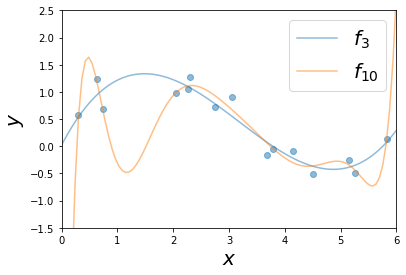

In [5]:
data = return_data(15, np.sin, noise=1)
f1 = Polynomial(w=get_w(data, order=3))
f2 = Polynomial(w=get_w(data, order=10))

X_ = np.linspace(0, 6, 100)
plt.plot(X_, f1(X_), alpha=0.5, label=r"$f_{%d}$"%f1.order)
plt.plot(X_, f2(X_), alpha=0.5, label=r"$f_{%d}$"%f2.order)
plot(data[0], data[1])
plt.legend(fontsize=20); plt.show()

$f_{10}$ はパラメータ数が多すぎるため、このデータだと明らかにoverfittingを引き起こすわけですが、これを今回は正則化で軽減してみましょう。要はパラメータが多すぎる、またはモデルがカバーできる範囲が広すぎる、ということなので、${\bf w}$ について下に凸な追加の項をくわえると、${\bf w}$ が大きい部分が実質禁止されるはずです。そこで適当な $\epsilon > 0$ について

$$
L'(w) = L(w) + \underbrace{\epsilon \frac{{\bf w}^2}{2}}_{\text{penalty term}}
$$

の最小化を考えてみましょう。加えた項は${\bf w}$ についての原点からの**L2距離** になっていのにで、これを**L2正則化**といいます。もとの最小二乗法の解の導出と同じことを繰り返すと

$$
{\bf w} = (X + \epsilon I)^{-1} {\bf \alpha}
$$

が解であることがわかります。これは以下のようにoverfittingを防ぐ効果があります：

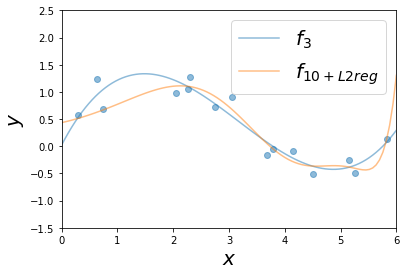

In [6]:
f1 = Polynomial(w=get_w(data, order=3))
f2 = Polynomial(w=get_regularized_w(data, order=10, epsilon=.1))

X_ = np.linspace(0, 6, 100)
plt.plot(X_, f1(X_), alpha=0.5, label=r"$f_{%d}$"%f1.order)
plt.plot(X_, f2(X_), alpha=0.5, label=r"$f_{%d+L2reg}$"%f2.order)
plot(data[0], data[1])
plt.legend(fontsize=20); plt.show()

L2正則化バージョンの誤差関数最小化で $f_{10}$ の振る舞いがマイルドになりました。

#### ニューラルネットでもやってみる
このような正則化をニューラルネットの訓練でも導入できます。それには経験誤差にネットワーク重み ${\bf w}$ からなるpenalty termを入れておけばよいのですが、これは`tf.keras.layer.Layer`を呼び出す際に、
* `kernel_regularizer=tf.keras.regularizers.l2()`

とすればlossに自分で追加しなくても自動でpenaltyを勾配更新の誤差に追加してくれるようです。

#### Dropout
もう一つ、今度はニューラルネットならではの正則化手法が**dropout**です。これは訓練中、各ミニバッチでの更新毎に、各データの処理を、dropout層の出力値の成分のうち一定割合をランダムにゼロにするものです。

![alt](dropout.jpg)

更新の度にゼロにされる成分は異なります。dropoutは`tf.keras.layers.Dropout(p)`で層のオブジェクトとして使えるようです：

In [8]:
f = tf.keras.layers.Dropout(0.5)
x = tf.ones((2, 5))
for _ in range(3):
    print(f(x, training=True))

tf.Tensor(
[[0. 0. 0. 0. 2.]
 [0. 2. 0. 0. 0.]], shape=(2, 5), dtype=float32)
tf.Tensor(
[[0. 0. 2. 0. 2.]
 [0. 2. 2. 2. 2.]], shape=(2, 5), dtype=float32)
tf.Tensor(
[[0. 0. 2. 2. 2.]
 [0. 2. 2. 2. 0.]], shape=(2, 5), dtype=float32)


ここで出力値成分が2倍になっていますが、これは50%の確率で値をdropoutしたぶん、シグナルが弱くなってしまうので、それを回復するため値をすべて $\times \frac{1}{1- p}$ 倍するようになっているためです。Dropoutは上手く使うと汎化性能を上げる効果があることが知られています。これはスキップ接続のときもコメントしたように、ニューラルネットワーク内の結合を毎回ランダムに切ったり着けたりしていると、全体として多数のネットワークを訓練していると考えられ、これが後述のアンサンブルに対応するというのが現状の理解です。

#### Vanilla vs BN vs Dropout vs L2正則化 vs 全部乗せ
以下ではCIFAR-10の分類ネットワークをいろいろな正則化や正規化を入れた場合で比べてみました：

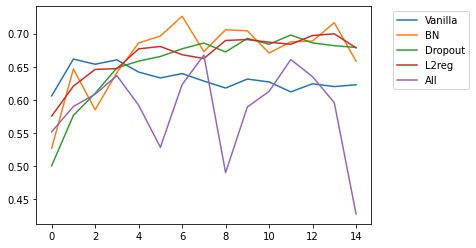

CPU times: user 8min 13s, sys: 49.7 s, total: 9min 3s
Wall time: 11min 28s


In [43]:
%%time
def plot_hist_val_accuracy(model, epochs, label):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    Hist= model.fit(train_images, train_labels, epochs=epochs, verbose=0, validation_data=(test_images, test_labels))
    plt.plot(np.arange(epochs), Hist.history['val_accuracy'], label=label)
    
epochs = 15

model = CNNModel(BN=False, dropout=False, L2reg_weight=0)
plot_hist_val_accuracy(model, epochs=epochs, label='Vanilla')

model = CNNModel(BN=True, dropout=False, L2reg_weight=0)
plot_hist_val_accuracy(model, epochs=epochs, label='BN')

model = CNNModel(BN=False, dropout=True, L2reg_weight=0)
plot_hist_val_accuracy(model, epochs=epochs, label='Dropout')

model = CNNModel(BN=False, dropout=False, L2reg_weight=0.001)
plot_hist_val_accuracy(model, epochs=epochs, label='L2reg')

model = CNNModel(BN=True, dropout=True, L2reg_weight=0.001)
plot_hist_val_accuracy(model, epochs=epochs, label='All')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.show()

この実験では BN, Dropout, L3正則化は大体同じくらいの性能を示し、それらを入れない（vanillaな）ネットワークに比べ高い検証精度を示しているのがわかります。ただし、全て同時に入れるとむしろ精度が悪くなりました。どれをスイッチオンするべきかは実験で決めるしか無い気がします…

### アンサンブル学習
ここまでの話では、どの場合でも基本的には1つのモデルを用いた機械学習の話でした。しかし、**三人寄れば文殊の知恵** と言うように、 **複数のモデルを訓練して協力して問題を解かせる** ということをやってもいいでしょう。実は、三人寄れば文殊の知恵、は機械学習においても有効な考え方なのです。複数のモデルから成る集合を **モデルのアンサンブル** といい、モデル1つではなく、アンサンブルを用いた機械学習手法を総称してアンサンブル学習と呼びます。

#### 素朴な説明
回帰問題を解かせることを考えます。つまり、入力 $x$ について、何らかの連続量 $y$ があるとき、その間の関数を推定する問題です。まず

$$
f_{\theta_i}(x), \quad i=1,2, \dots, N_\text{esb}
$$

$N_\text{esb}$個の「訓練済み」モデルとします。この元で、アンサンブルモデル $f$ の出力を これらの平均

$$
f(x) = \frac{1}{N_\text{esb}} \sum_{i} f_{\theta_i}(x)
$$

とします。アンサンブルモデルの汎化誤差は、$P$ をデータ生成確率として、

$$
\left. \begin{array}{ll}
E := \langle (f(x) - y)^2 \rangle_{x,y \sim P} &=
\Big\langle \Big( \frac{1}{N_\text{esb}} \sum_{i} f_{\theta_i}(x) - y \Big)^2 \Big\rangle_{x,y \sim P}
\\&= 
\Big\langle \Big( \frac{1}{N_\text{esb}} \sum_{i} \big[\underbrace{ f_{\theta_i}(x) - y}_{\epsilon_i(x, y)} \big] \Big)^2 \Big\rangle_{x,y \sim P}
\\&= 
\frac{1}{N_\text{esb}^2} \Big\langle \sum_{i} \epsilon_i(x, y)^2  + \sum_{i \neq j} \epsilon_i(x, y)\epsilon_j(x, y) \Big\rangle_{x,y \sim P}
\\&= 
\frac{1}{N_\text{esb}^2}  \sum_{i} \langle \epsilon_i(x, y)^2 \rangle_{x,y \sim P}  + \frac{1}{N_\text{esb}^2}  \sum_{i \neq j} \langle \epsilon_i(x, y)\epsilon_j(x, y) \rangle_{x,y \sim P}
\end{array} \right.
$$


と表せるのがわかりました。ここで以下の仮定を置くことができる場合を考えます：
* 各モデルは同程度の汎化性能を持つ：$\forall i, \quad \langle \epsilon_i(x, y)^2 \rangle_{x,y\sim P} = \epsilon$
* 各モデルは独立である：$\forall i, j, s.t. i\neq j, \quad \langle \epsilon_i(x, y) \epsilon_j(x, y) \rangle_{x,y\sim P} = 0$

すると上の式で1項目だけが生き残り、アンサンブルモデルの汎化誤差は

$$
E = \frac{\epsilon}{N_\text{esb}} 
$$

と、1つのモデルの汎化誤差の$\frac{1}{N_\text{esb}}$ になることがわかります。これは汎化性能が上がったということを意味します。

#### 分類問題での多数決
上の説明は回帰の場合だったので、分類タスクの場合はどうなんだと思われるかもしれません。こちらの場合によくある説明は以下のとおりです：

モデルが $N_\text{esb}$ 個あるとして、これがやはり
* 同程度の性能：等しく確率 $\theta$ で間違える
* 独立である

とします。すると、$N_\text{esb}$個のモデルのうち $n$ 個が間違える確率は上の仮定から二項分布

$$
P_\text{wrong}(n, \theta; N_\text{esb}) = \left( \begin{array}{c}
 N_\text{esb} \\
 n \\
\end{array} \right)
\theta^n (1- \theta)^{N_\text{esb}- n}
$$

に従うはずです。このときアンサンブル模型は、$N_\text{esb}$個のモデルの分類予想の多数決を採ることにします。アンサンブルモデルが間違う確率 は 過半数が間違える確率ではあり**ません**が、この２つをだいたい同じとみなし、アンサンブルモデルが間違う確率を

$$
P = \sum_{n>N_\text{esb}/2} P_\text{wrong}(n, \theta; N_\text{esb})
$$

で近似してみると、これは二項分布の外側の積分となっており、

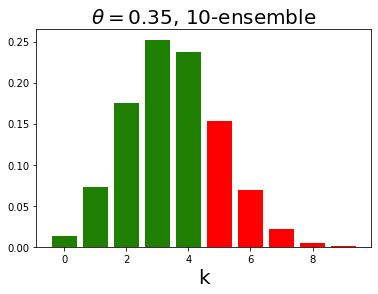

P=0.24847690540791012


In [43]:
plot_mass(K=10, theta=.35)

赤い部分の和が P の値ですが、これをアンサンブルが間違える確率と近似すると、1つのモデルが間違える確率 $\theta$ が 0.5 より小さいときは間違える確率が下がっているのがわかります。とはいっても、 P はアンサンブルが間違える確率そのものではありませんから、注意してください。

#### ニューラルネットで試してみる

ここではCIFAR-10の分類器を畳み込みニューラルネットワークで作ることを何度か（データは共有だけども）独立した状況で行い、それぞれの性能とそれらのアンサンブル（多数決投票）との性能の差が実際に現れることを実験してみます：

traial-0, val_accuracy=0.6929
traial-1, val_accuracy=0.6378
traial-2, val_accuracy=0.6912
traial-3, val_accuracy=0.7114
traial-4, val_accuracy=0.6742
ensemble, val_accuracy=0.7375


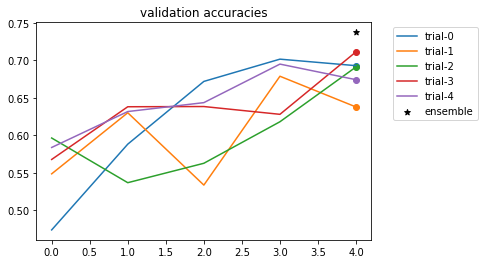

CPU times: user 3min 16s, sys: 18.4 s, total: 3min 34s
Wall time: 4min 34s


In [9]:
%%time
def run_trial(epochs=3, N_esb=5):
    models = []
    plt.title("validation accuracies")
    for i in range(N_esb):
        model = CNNModel(BN=True, dropout=True, L2reg_weight=0)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        Hist= model.fit(train_images, train_labels, epochs=epochs, verbose=0, validation_data=(test_images, test_labels))
        plt.plot(np.arange(epochs), Hist.history['val_accuracy'], label='trial-%d'%i)
        score = measure(model, test_images, test_labels)
        print("traial-{}, val_accuracy={}".format(i, score))
        plt.scatter(epochs-1, score)
        models.append(model)
    #
    score = measure_esb(models, test_images, test_labels)
    print("ensemble, val_accuracy={}".format(score))
    plt.scatter(epochs-1, score, marker="*", color='black', label='ensemble')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

run_trial(epochs=5)

このデモで適当に設計したモデルでしたが、その範囲内でいくつか実験してみた結果、BN+dropoutが一番成績が良かったので、その設定で5つのモデルから成るアンサンブルを作り、それの投票数で予想を決めるアンサンブルを作ると、上のように一つ一つのモデルの精度を上回る結果になりました。いくつか実験していただくと良いかと思いますが、アンサンブルによる汎化性能向上はかなりの確率で上手くいくことが見込めます。ただし、ここでのmajority voting によるアンサンブルには上手くいく条件があって、それは
* 全てのモデルの精度が同等に良い

ということです。そうでない場合、例えば良い精度を示すモデルが有る一方で悪い精度を示すモデルが多数ある場合、そちらの票が足を引っ張って、アンサンブルの予測はその中の最良のモデル精度よりもむしろ悪くなる場合があります。
> 例えば、ここのデモンストレーションをはじめアヤメデータでやろうとしましたが、適当にネットワークを作ったせいか、精度がバラけて上手くいきませんでした。

#### BaggingとBoosting
上のデモンストレーションは、**バギング(Bagging)** と呼ばれる手法に近い方法です。バギングとはブートストラップ毎の集計(bootstrap aggregating)の略で、与えられたデータからのランダムサンプリングによって作った「部分データ」を用いてモデルを訓練することを複数回やり、手に入ったモデルをアンサンブルとすることで汎化性能を上げようとする手法です。

有名なアンサンブル学習に、**ブースティング(Boosting)** というテクニックもあります。これは順番にモデルを作ってアンサンブルに追加していく中で、現在のモデルの上手く行っていない部分をカバーするように新しいモデルを決定してゆく手法です。

教師あり学習の精度が思うように上がらないとき、単なる一つのモデルに縛られず、このようなアンサンブル手法を使ってみることも考慮してみるのが良いかも知れません。